In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import random
import cv2
import tqdm as tqdm
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import os
root_dir = "/content/drive/My Drive/weather_data/dataset/"
os.listdir(root_dir)

['test.csv', 'shine', 'cloudy', 'sunrise', 'foggy', 'alien_test', 'rainy']

In [ ]:
foggy = "/content/drive/My Drive/weather_data/dataset/foggy"
sunrise = "/content/drive/My Drive/weather_data/dataset/sunrise"
shine = "/content/drive/My Drive/weather_data/dataset/shine"
rainy = "/content/drive/My Drive/weather_data/dataset/rainy"
cloudy = "/content/drive/My Drive/weather_data/dataset/cloudy"
test = "/content/drive/My Drive/weather_data/dataset/alien_test"

In [ ]:
print("Number of Images in Each Directory:")
print(f"Foggy: {len(os.listdir(foggy))}")
print(f"Sunrise: {len(os.listdir(sunrise))}")
print(f"Shine: {len(os.listdir(shine))}")
print(f"Rainy: {len(os.listdir(rainy))}")
print(f"Cloudy: {len(os.listdir(cloudy))}")

Number of Images in Each Directory:
Foggy: 300
Sunrise: 350
Shine: 250
Rainy: 300
Cloudy: 300


In [ ]:
x = []
y = [] 
dataset =[]
def create_dataset(directory,dir_name):
    for i in tqdm.tqdm(os.listdir(directory)):
        full_path = os.path.join(directory,i)
        try:
            img = cv2.imread(full_path)
            img = cv2.resize(img,(150,150))
        except:
            continue
        x.append(img)
        y.append(dir_name)
    return x,y

In [ ]:
x,y= create_dataset(foggy,"foggy")
x,y= create_dataset(sunrise,"sunrise")
x,y= create_dataset(shine,"shine")
x,y= create_dataset(rainy,"rainy")
x,y= create_dataset(cloudy,"cloudy")

100%|██████████| 300/300 [00:01<00:00, 163.57it/s]


In [ ]:
x =  np.array(x)
y = np.array(y)
x.shape,y.shape

((1498, 150, 150, 3), (1498,))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


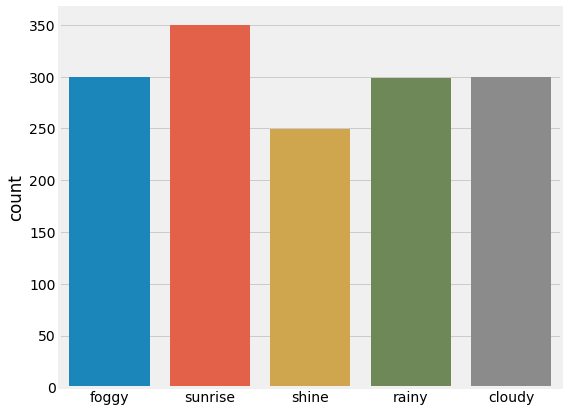

In [ ]:
import seaborn as sns
plt.figure(figsize=(9,7))
plt.style.use("fivethirtyeight")
sns.countplot(y)
plt.show()

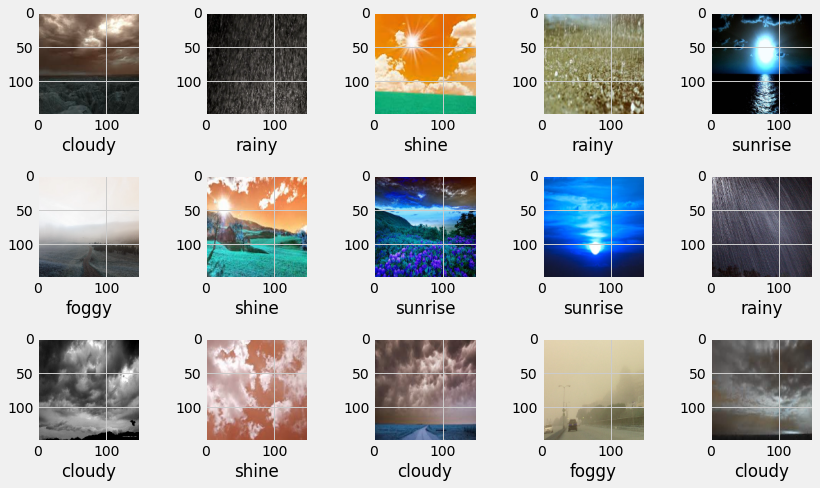

In [ ]:
fig = plt.figure(figsize=(12,7))
for i in range(15):
    sample =  random.choice(range(len(x)))
    image = x[sample]
    category = y[sample]
    plt.subplot(3,5,i+1)
    plt.subplots_adjust(hspace=0.3)
    plt.imshow(image)
    plt.xlabel(category)
    
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.1,random_state=42)

In [ ]:
img_size =150

x_train = np.array(x_train)/255.0
x_test = np.array(x_test)/255.0


x_train = x_train.reshape(-1,img_size,img_size,3)
y_train = np.array(y_train)

x_test = x_test.reshape(-1,img_size,img_size,3)
y_test = np.array(y_test)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y_train_lb = lb.fit_transform(y_train)
y_test_lb = lb.fit_transform(y_test)

In [ ]:
y_train_lb.shape,y_test_lb.shape

((1348, 5), (150, 5))

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(input_shape = (150, 150, 3), include_top = False, weights = 'imagenet')

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model =Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(5,activation="softmax"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 5)                 92165     
Total params: 21,894,949
Trainable params: 92,165
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
from tensorflow.keras.optimizers import RMSprop
model.compile(optimizer= RMSprop(lr=0.0001),loss="binary_crossentropy",metrics="accuracy")

from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("inceptionv3.h5",monitor="val_accuracy",verbose=1,save_best_only=True,
                             save_weights_only=False)
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
unique,counts = np.unique(y_train_lb,return_counts=True)
print(unique,counts)

[0 1] [5392 1348]


In [ ]:
batch_size=32
history =  model.fit(x_train,y_train_lb,epochs=15,validation_data=(x_test,y_test_lb),
                     batch_size=32 ,verbose=1,callbacks=[checkpoint,earlystop])

Epoch 1/15
43/43 [==============================] - 63s 1s/step - loss: 0.4323 - accuracy: 0.5645 - val_loss: 0.3392 - val_accuracy: 0.6600

Epoch 00001: val_accuracy improved from -inf to 0.66000, saving model to inceptionv3.h5
Epoch 2/15
43/43 [==============================] - 58s 1s/step - loss: 0.2466 - accuracy: 0.8190 - val_loss: 0.2676 - val_accuracy: 0.8200

Epoch 00002: val_accuracy improved from 0.66000 to 0.82000, saving model to inceptionv3.h5
Epoch 3/15
43/43 [==============================] - 58s 1s/step - loss: 0.1780 - accuracy: 0.9050 - val_loss: 0.2360 - val_accuracy: 0.7933

Epoch 00003: val_accuracy did not improve from 0.82000
Epoch 4/15
43/43 [==============================] - 58s 1s/step - loss: 0.1384 - accuracy: 0.9332 - val_loss: 0.2006 - val_accuracy: 0.8267

Epoch 00004: val_accuracy improved from 0.82000 to 0.82667, saving model to inceptionv3.h5
Epoch 5/15
43/43 [==============================] - 58s 1s/step - loss: 0.1106 - accuracy: 0.9547 - val_loss: 0

In [ ]:
loss,accuracy = model.evaluate(x_test,y_test_lb)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}") 

5/5 [==============================] - 6s 1s/step - loss: 0.1556 - accuracy: 0.8867
Loss: 0.15558472275733948
Accuracy: 0.8866666555404663


In [ ]:
y_pred = model.predict_classes(x_test)
y_pred[:15]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([1, 0, 0, 0, 3, 3, 2, 3, 4, 1, 3, 1, 0, 0, 1])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.88      0.94        26
           1       0.74      0.97      0.84        30
           2       0.89      0.86      0.88        29
           3       0.92      0.92      0.92        25
           4       0.94      0.82      0.88        40

    accuracy                           0.89       150
   macro avg       0.90      0.89      0.89       150
weighted avg       0.90      0.89      0.89       150



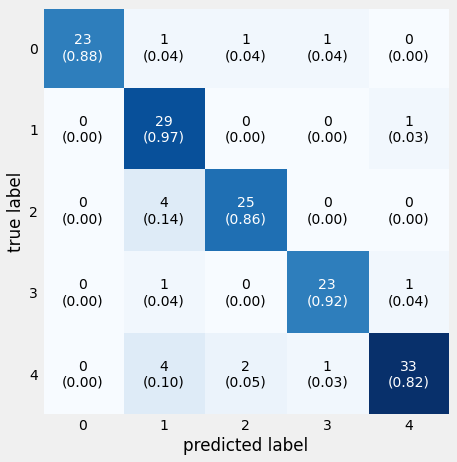

In [ ]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(conf_mat = cm, figsize=(8,7), show_normed = True);

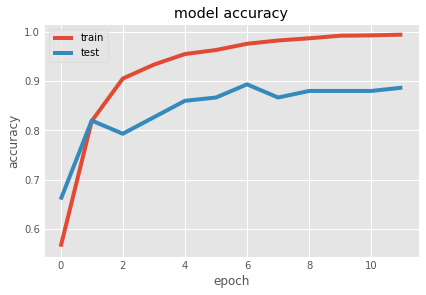

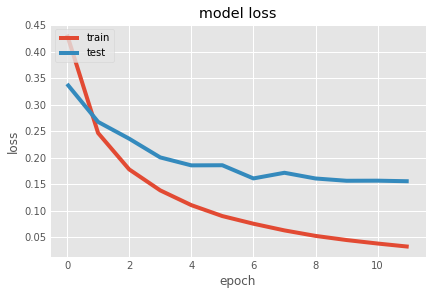

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

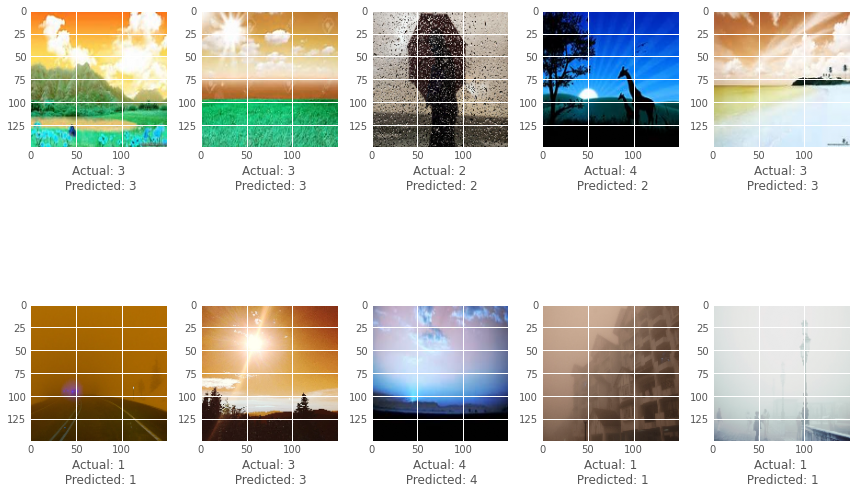

In [ ]:
plt.figure(figsize=(12,9))
plt.style.use("ggplot")
for i in range(10):
    sample = random.choice(range(len(x_test)))
    plt.subplot(2,5,i+1)
    plt.subplots_adjust(hspace=0.3)
    plt.imshow(x_test[sample])
    plt.xlabel(f"Actual: {y_test[sample]}\n Predicted: {y_pred[sample]}")
    
plt.tight_layout()    
plt.show()   